In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download bayuokta/wayang-bagong-cepot-gareng-petruk-semar

 91% 41.0M/44.9M [00:01<00:00, 45.0MB/s]
100% 44.9M/44.9M [00:01<00:00, 39.9MB/s]


In [ ]:
! unzip -qq wayang-bagong-cepot-gareng-petruk-semar.zip

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [ ]:
data_dir = "images"
train_dir= "images/train/"
val_dir = "images/val/"
test_dir = "images/test/"

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (300, 300),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical')

Found 1350 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

class myCallback (tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.99):
      self.model.stop_training = True
      print("\nThe accuracy has reached > 99%!")
callbacks = myCallback()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('Wacayang_ResNet_Model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet152V2

model = tf.keras.Sequential([
    ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=(300, 300, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 10, 10, 2048)      58331648  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               26214528  
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 84,546,821
Trainable params: 26,215,173
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
# Compile the Neural network
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_set, epochs = 100, validation_data = validation_generator, verbose = 1, callbacks=[callbacks, es, mc])

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 11.0417 - accuracy: 0.6919
Epoch 1: val_accuracy improved from -inf to 0.89333, saving model to Wacayang_ResNet_Model.h5
43/43 [==============================] - 46s 887ms/step - loss: 11.0417 - accuracy: 0.6919 - val_loss: 0.6369 - val_accuracy: 0.8933
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.9230
Epoch 2: val_accuracy improved from 0.89333 to 0.92000, saving model to Wacayang_ResNet_Model.h5
43/43 [==============================] - 37s 863ms/step - loss: 0.3147 - accuracy: 0.9230 - val_loss: 0.1818 - val_accuracy: 0.9200
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9607
Epoch 3: val_accuracy did not improve from 0.92000
43/43 [==============================] - 34s 778ms/step - loss: 0.1145 - accuracy: 0.9607 - val_loss: 0.1727 - val_accuracy: 0.9067
Epoch 4/100
43/43 [==============================] - ETA: 0s - loss: 0.0943

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


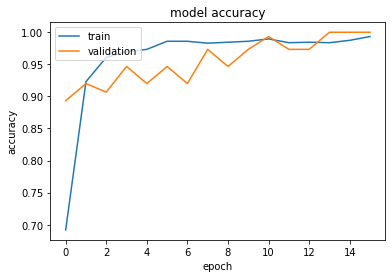

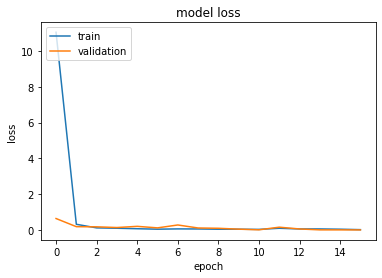

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
import cv2
import numpy as np
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from PIL import Image

classes = ['bagong', 'cepot', 'gareng', 'petruk', 'semar']

loaded_model = load_model('Wacayang_ResNet_Model.h5')

image_testing = Image.open('/content/cepot.jpeg')
image_testing = np.array(image_testing.resize((300, 300))) / 255.0
image_testing.shape

image_testing = np.expand_dims(image_testing, axis=0)
print(image_testing.shape)

output = model.predict(image_testing)
best_index = np.argmax(output)
class_name = classes[best_index]

print(output)
print(best_index)

(1, 300, 300, 3)
[[7.5480159e-25 1.0000000e+00 3.0098963e-23 1.6331971e-30 5.9996904e-19]]
1


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Wacayang/test',
                                            target_size = (300, 300),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 150 images belonging to 5 classes.


In [ ]:
score = model.evaluate(test_set, return_dict=True, verbose=0)

In [ ]:
print(score)

{'loss': 0.00041236431570723653, 'accuracy': 1.0}


In [ ]:
cd  /content/drive/MyDrive/Colab Notebooks/Wacayang

/content/drive/MyDrive/Colab Notebooks/Wacayang


In [ ]:
model.save('Wacayang_ResNet_Model.h5')